# Deep Learning Project | Ampalaya Leaf NPK Deficiency Detection | InceptionV3

In [1]:
# TensorFlow and Keras for model building
import tensorflow as tf
from keras import layers
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

# Other utilities
import os
import numpy as np
import matplotlib.pyplot as plt

Constants

In [2]:
IMAGE_SIZE = 299
BATCH_SIZE = 64
CLASSES = 4
EPOCHS = 50

Dataset directory declaration

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"C://Users//REYES//OneDrive//Desktop//CNN_Projects//DATASETS//AMPALAYA_DS", #Folder name or directory
shuffle=True,
image_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE
)

#Calls and Displays class names from dataset
class_names = dataset.class_names
class_names 

Found 2300 files belonging to 4 classes.


['Healthy',
 'Nitrogen Deficient',
 'Phosphorus Deficient',
 'Potassium Deficient']

# Plot 3 images each from their respective classes

In [ ]:
# Assuming 'dataset' is a tf.data.Dataset object and class_names is defined
class_names_of_interest = ['Healthy', 'Nitrogen Deficient', 'Phosphorus Deficient', 'Potassium Deficient']
class_indices = [class_names.index(name) for name in class_names_of_interest]  # Get class indices

healthy_images = {name: [] for name in class_names_of_interest}  # Create a dictionary to store images

# Extract images for the specified classes from the dataset
for images, labels in dataset:
    for i in range(len(labels)):
        label = labels[i].numpy()  # Convert to numpy for easier comparison
        if label in class_indices and len(healthy_images[class_names[label]]) < 3:
            healthy_images[class_names[label]].append((images[i], labels[i]))  # Store image and label
        # Stop collecting images if all three classes have 3 images each
        if all(len(healthy_images[name]) == 3 for name in class_names_of_interest):
            break
    if all(len(healthy_images[name]) == 3 for name in class_names_of_interest):
        break

# Plot the images for each class
plt.figure(figsize=(15, 15))
for i, name in enumerate(class_names_of_interest):
    for j, (image, label) in enumerate(healthy_images[name]):
        ax = plt.subplot(len(class_names_of_interest), 3, i * 3 + j + 1)  # Each class in a row
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(name)  # Set title to class name
        plt.axis("off")

plt.tight_layout()
plt.show()

# Splitting Dataset to 80-10-10, training, validation and test respectively

In [4]:
# Function for augmenting images using preprocessing layers
def Crop(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image

    return image

def Rotate(image):
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image

    return image

def Contrast(image):
    image = keras.layers.RandomContrast(0.1)(image)  # Randomly adjust contrast

    return image

def Flip(image):
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image

    return image

def Brightness(image):
    image = keras.layers.RandomBrightness([0.1, 0.2])(image)  # Randomly adjust brightness

    return image

# Function for augmenting images using preprocessing layers
def augment(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image
    image = keras.layers.RandomContrast(0.1)(image)  # Randomly adjust contrast
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image
    image = keras.layers.RandomBrightness([0.1, 0.2])(image)  # Randomly adjust brightness

    return image

# Load and augment the training set
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000, augment_data=True):
    
    # Get length of dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle dataset before splitting
    
    # Compute percentage accordingly from dataset size
    train_size = int(train_split * ds_size) 
    val_size = int(val_split * ds_size) 
    
    # Split the dataset into training, validation, and test sets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    if augment_data:
    # Apply augmentation only to the training set
        #augmented_train_ds = train_ds.map(lambda x, y: (augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        #cropped_train_ds = train_ds.map(lambda x, y: (Crop(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        rotated_train_ds = train_ds.map(lambda x, y: (Rotate(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        contrasted_train_ds = train_ds.map(lambda x, y: (Contrast(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        #flipped_train_ds = train_ds.map(lambda x, y: (Flip(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        brightness_train_ds = train_ds.map(lambda x, y: (Brightness(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
    # Concatenate the original training data with the augmented data
       #train_ds = train_ds.concatenate(augmented_train_ds)
       #train_ds = train_ds.concatenate(cropped_train_ds)
        train_ds = train_ds.concatenate(rotated_train_ds)
        train_ds = train_ds.concatenate(contrasted_train_ds)
       #train_ds = train_ds.concatenate(flipped_train_ds)
        train_ds = train_ds.concatenate(brightness_train_ds)
    
    return train_ds, val_ds, test_ds

# Assuming you already loaded your dataset into `dataset`
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Shuffling and Cache the dataset for faster model training

In [5]:
tf.random.set_seed(42)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

Show train_ds samples. Augmented and Non-Augmented

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# Load InceptionV3 Model

In [6]:
from tensorflow.keras.regularizers import L2

inception_model = keras.Sequential()

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg', classes=4)
predictions = Dense(4, activation='softmax')

for layer in base_model.layers:
    layer.trainable = False

#Reached 60% F1 score with this one
# inception_model.add(base_model)
# inception_model.add(layers.Flatten())
# inception_model.add(layers.Dense(32, activation='relu', kernel_regularizer=L2(0.01)))
# inception_model.add(layers.BatchNormalization())
# inception_model.add(layers.Dropout(0.1))
# inception_model.add(layers.Dense(32, activation='relu'))
# inception_model.add(layers.BatchNormalization())


inception_model.add(base_model)
inception_model.add(layers.Flatten())
inception_model.add(layers.Dense(256, activation='relu', kernel_regularizer=L2(0.01)))
inception_model.add(layers.BatchNormalization())
inception_model.add(layers.Dropout(0.5))
inception_model.add(layers.Dense(128, activation='relu', kernel_regularizer=L2(0.01)))
inception_model.add(layers.BatchNormalization())

inception_model.add(layers.Dense(64, activation='relu', kernel_regularizer=L2(0.01)))
inception_model.add(layers.Dropout(0.2))
inception_model.add(layers.Dense(64, activation='relu'))
inception_model.add(layers.BatchNormalization())
inception_model.add(predictions)

inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_94 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

In [ ]:
keras.utils.plot_model(inception_model, show_shapes=True)

In [7]:
# # Compile the model with an Adam optimizer and categorical crossentropy loss
inception_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# # Compile the model with an Adam optimizer and categorical crossentropy loss
# resnet_model.compile(optimizer=RMSprop(learning_rate=0.001), 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])

# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# inception_model.compile(optimizer=optimizer, 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# #create a callback function to stop training when the validation loss does not improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [9]:
# Train the model on the dataset
history = inception_model.fit(
    train_ds,
    epochs=50,  # You can increase the number of epochs based on your dataset
    validation_data=val_ds,
    #callbacks=[stop_early, lr_scheduler]
)

Epoch 1/50
112/112 [==============================] - 193s 539ms/step - loss: 8.0457 - accuracy: 0.4071 - val_loss: 7.4376 - val_accuracy: 0.4115
Epoch 2/50
112/112 [==============================] - 30s 267ms/step - loss: 6.8743 - accuracy: 0.5318 - val_loss: 6.2665 - val_accuracy: 0.6198
Epoch 3/50
112/112 [==============================] - 25s 225ms/step - loss: 6.1217 - accuracy: 0.5867 - val_loss: 5.6226 - val_accuracy: 0.6927
Epoch 4/50
112/112 [==============================] - 25s 226ms/step - loss: 5.5616 - accuracy: 0.6070 - val_loss: 5.1264 - val_accuracy: 0.7448
Epoch 5/50
112/112 [==============================] - 25s 227ms/step - loss: 5.1085 - accuracy: 0.6380 - val_loss: 4.6867 - val_accuracy: 0.7969
Epoch 6/50
112/112 [==============================] - 25s 227ms/step - loss: 4.7356 - accuracy: 0.6563 - val_loss: 4.3644 - val_accuracy: 0.7760
Epoch 7/50
112/112 [==============================] - 25s 227ms/step - loss: 4.4144 - accuracy: 0.6761 - val_loss: 4.0772 - val_a

# Model Evualuation

In [10]:
scores = inception_model.evaluate(test_ds) # Without Fine-Tuning

5/5 [==============================] - 35s 216ms/step - loss: 0.7491 - accuracy: 0.8969


In [12]:
#show highest accuracy and validation accuracy show lowest loss and validation loss and latest of each
print("Highest Accuracy: ", max(history.history['accuracy']))
print("Highest Validation Accuracy: ", max(history.history['val_accuracy']))
print("Lowest Loss: ", min(history.history['loss']))
print("Lowest Validation Loss: ", min(history.history['val_loss']))
print("Final Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Loss: ", history.history['loss'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])

Highest Accuracy:  0.8403631448745728
Highest Validation Accuracy:  0.921875
Lowest Loss:  0.8932560086250305
Lowest Validation Loss:  0.7070355415344238
Final Accuracy:  0.8303072452545166
Final Validation Accuracy:  0.9166666865348816
Final Loss:  0.8932560086250305
Final Validation Loss:  0.7070355415344238


In [18]:
# code to view f1 score and other metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = inception_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

5/5 [==============================] - 1s 212ms/step
F1 Score: 0.5076617598137059
Precision: 0.5106704979507626
Recall: 0.50625
Accuracy: 0.50625
              precision    recall  f1-score   support

           0       0.42      0.47      0.44        78
           1       0.56      0.52      0.54        98
           2       0.54      0.54      0.54        78
           3       0.52      0.48      0.50        66

    accuracy                           0.51       320
   macro avg       0.51      0.50      0.51       320
weighted avg       0.51      0.51      0.51       320



# Un-Freeze and Fine-tune the model

In [22]:
# Unfreeze only a subset of layers
for layer in base_model.layers[:80]:  # Freeze the first 100 layers
    layer.trainable = False
for layer in base_model.layers[80:]:  # Unfreeze the rest
    layer.trainable = True

# Recompile the model for fine-tuning (with a lower learning rate)
inception_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [23]:
inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_94 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

Continue training the entire model

In [24]:
history_finetune = inception_model.fit(
    train_ds,
    epochs=5,  # Additional epochs for fine-tuning
    batch_size = 64,
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler]
)

Epoch 1/5
112/112 [==============================] - 82s 609ms/step - loss: 1.0807 - accuracy: 0.7704 - val_loss: 3.3976 - val_accuracy: 0.2760 - lr: 1.0000e-04
Epoch 2/5
112/112 [==============================] - 62s 557ms/step - loss: 0.6378 - accuracy: 0.9145 - val_loss: 0.8610 - val_accuracy: 0.8073 - lr: 1.0000e-04
Epoch 3/5
112/112 [==============================] - 63s 563ms/step - loss: 0.5015 - accuracy: 0.9567 - val_loss: 0.5144 - val_accuracy: 0.9635 - lr: 1.0000e-04
Epoch 4/5
112/112 [==============================] - 63s 564ms/step - loss: 0.4235 - accuracy: 0.9802 - val_loss: 0.6413 - val_accuracy: 0.9323 - lr: 1.0000e-04
Epoch 5/5
112/112 [==============================] - 63s 565ms/step - loss: 0.4162 - accuracy: 0.9742 - val_loss: 0.3531 - val_accuracy: 0.9948 - lr: 1.0000e-04


In [25]:
#show highest accuracy and validation accuracy show lowest loss and validation loss and latest of each
print("Highest Accuracy: ", max(history_finetune.history['accuracy']))
print("Highest Validation Accuracy: ", max(history_finetune.history['val_accuracy']))
print("Lowest Loss: ", min(history_finetune.history['loss']))
print("Lowest Validation Loss: ", min(history_finetune.history['val_loss']))
print("Final Accuracy: ", history_finetune.history['accuracy'][-1])
print("Final Validation Accuracy: ", history_finetune.history['val_accuracy'][-1])
print("Final Loss: ", history_finetune.history['loss'][-1])
print("Final Validation Loss: ", history_finetune.history['val_loss'][-1])

Highest Accuracy:  0.9801676273345947
Highest Validation Accuracy:  0.9947916865348816
Lowest Loss:  0.4161834418773651
Lowest Validation Loss:  0.35306206345558167
Final Accuracy:  0.9741619825363159
Final Validation Accuracy:  0.9947916865348816
Final Loss:  0.4161834418773651
Final Validation Loss:  0.35306206345558167


In [26]:
scores = inception_model.evaluate(test_ds) # With Fine Tuning

5/5 [==============================] - 1s 221ms/step - loss: 0.3789 - accuracy: 0.9875


In [34]:
y_pred = inception_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

5/5 [==============================] - 1s 212ms/step
F1 Score: 0.6967992828067455
Precision: 0.6968411377708978
Recall: 0.696875
Accuracy: 0.696875
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        78
           1       0.77      0.77      0.77        98
           2       0.65      0.65      0.65        78
           3       0.68      0.70      0.69        66

    accuracy                           0.70       320
   macro avg       0.69      0.69      0.69       320
weighted avg       0.70      0.70      0.70       320



# Plotting History | No Fine-Tuning

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

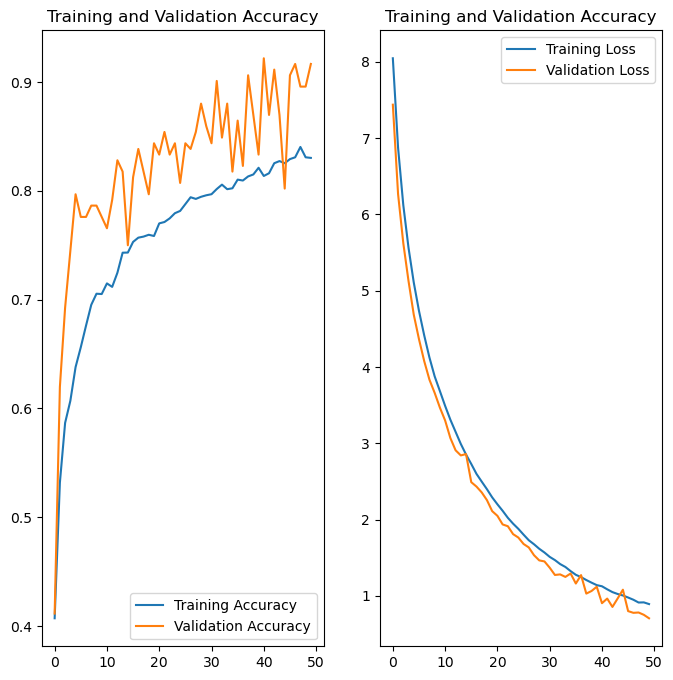

In [36]:
completed_epochs = len(history.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs), acc, label='Training Accuracy')
plt.plot(range(completed_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs), loss, label='Training Loss')
plt.plot(range(completed_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plotting History | With Fine-Tuning

In [37]:
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']

loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

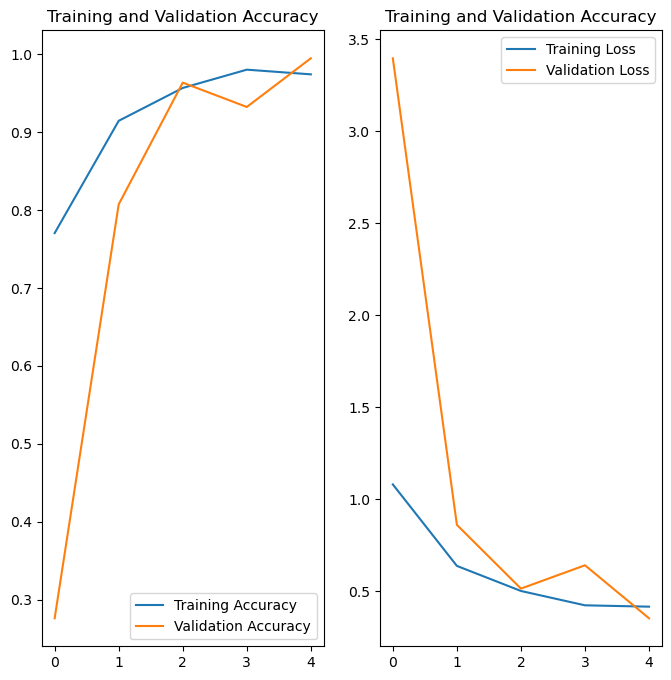

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(5), acc, label='Training Accuracy')
plt.plot(range(5), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(5), loss, label='Training Loss')
plt.plot(range(5), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

# Making a Prediction

Conusion Matrix

5/5 [==============================] - 1s 268ms/step


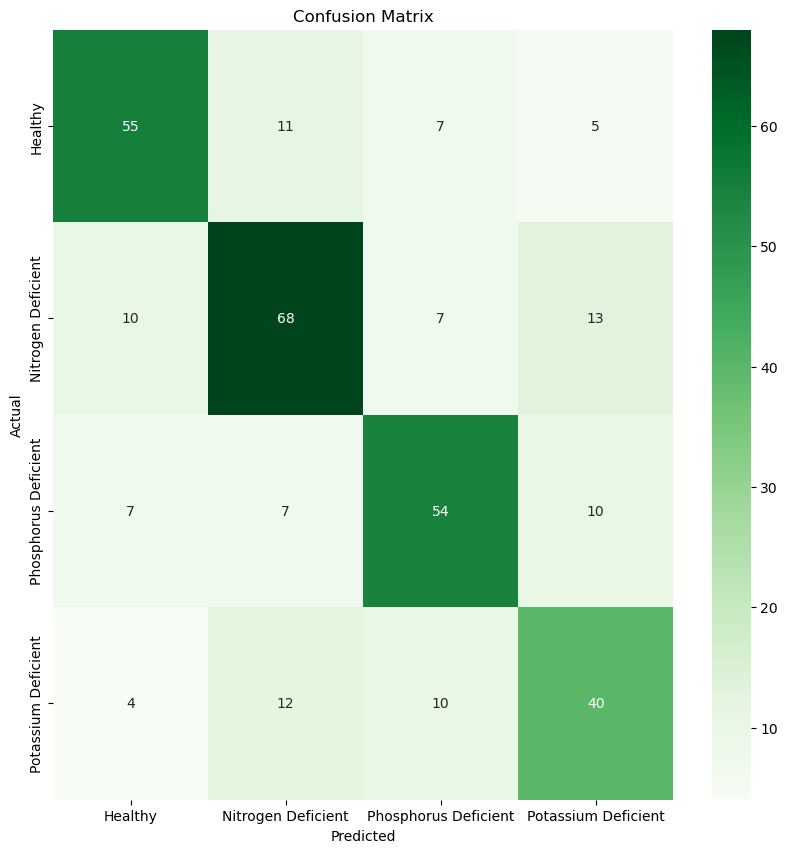

In [42]:
#code block to show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = inception_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


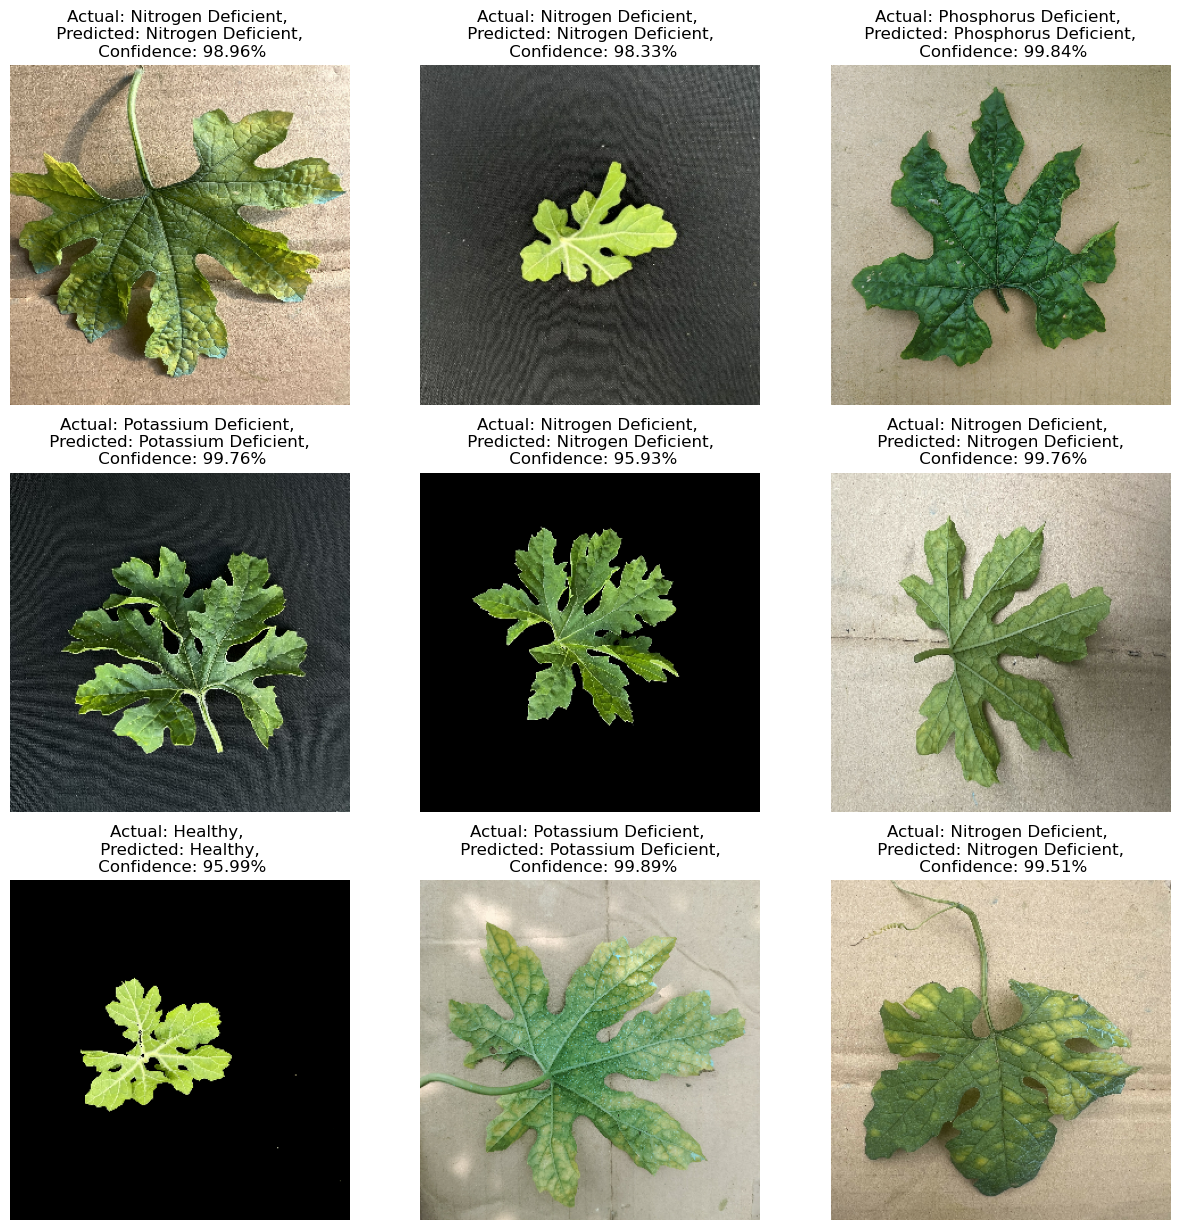

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(inception_model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving Model

In [47]:
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
inception_model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
